In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
# 机器学习packages
import sklearn #collection of machine learning algorithms
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
print("scikit-learn version: {}". format(sklearn.__version__))
### 其他
import cloudpickle as pickle
from biom import load_table
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

scikit-learn version: 1.0.2


# 1. Data Deal

In [2]:
data = pd.read_csv('../Data/2.modelData_new.csv')
data.shape
data.head(2)

(743, 11)

,住院号,DiagSepsis,心率_次/分,中性粒细胞绝对值_×10^9/L,白细胞计数_×10^9/L,白球比例_NULL,天门冬氨酸氨基转移酶_U/L,钙_mmol/L,γ-谷氨酰基转移酶_U/L,超敏C反应蛋白_mg/L,前白蛋白_mg/L
0,65000428,1,132.0,27.35,31.63,1.11,23.0,2.40,14.0,167.70,93.0
1,65153247,0,98.0,2.68,5.27,1.76,27.0,2.44,12.0,0.43,208.0


In [3]:
#使用平均值补齐
mdata = data.fillna(data.mean())  # 对特征使用均值填充
print(mdata.isnull().sum())  # 查看每列是否有缺失值

住院号                 0
DiagSepsis          0
心率_次/分              0
中性粒细胞绝对值_×10^9/L    0
白细胞计数_×10^9/L       0
白球比例_NULL           0
天门冬氨酸氨基转移酶_U/L      0
钙_mmol/L            0
γ-谷氨酰基转移酶_U/L       0
超敏C反应蛋白_mg/L        0
前白蛋白_mg/L           0
dtype: int64


## 1.1 split training and test set

In [4]:
select_cols=mdata.columns[2:11]
X=mdata.loc[:,select_cols]
y=mdata['DiagSepsis']
X.head(2)

,心率_次/分,中性粒细胞绝对值_×10^9/L,白细胞计数_×10^9/L,白球比例_NULL,天门冬氨酸氨基转移酶_U/L,钙_mmol/L,γ-谷氨酰基转移酶_U/L,超敏C反应蛋白_mg/L,前白蛋白_mg/L
0,132.0,27.35,31.63,1.11,23.0,2.40,14.0,167.70,93.0
1,98.0,2.68,5.27,1.76,27.0,2.44,12.0,0.43,208.0


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.4, 
                                                                    random_state = 0,
                                                                    stratify=y)
X_train.shape, X_test.shape
print("----------train set---------")
y_train.value_counts()
print("----------test set---------")
y_test.value_counts()

((445, 9), (298, 9))

----------train set---------


0    258
1    187
Name: DiagSepsis, dtype: int64

----------test set---------


0    172
1    126
Name: DiagSepsis, dtype: int64

# 2. Model selection

In [6]:
# 设置10折交叉验证分组
cv_split = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=.4, random_state=1)

In [7]:
# Train the classifier on the training data
print("----------------LogisticRegression----------------")
clf = linear_model.LogisticRegression(random_state=0)
lr_auc=model_selection.cross_validate(clf, X_train, y_train, cv=cv_split, scoring='roc_auc')['test_score']
lr_auc
print(np.mean(lr_auc),"±",np.std(lr_auc))
print("----------------RandomForestClassifier----------------")
clf = ensemble.RandomForestClassifier(random_state=0)
rf_auc=model_selection.cross_validate(clf, X_train, y_train, cv=cv_split, scoring='roc_auc')['test_score']
rf_auc
print(np.mean(rf_auc),"±",np.std(rf_auc))
print("----------------neural network----------------")
clf = MLPClassifier(random_state=0)
nn_auc=model_selection.cross_validate(clf, X_train, y_train, cv=cv_split, scoring='roc_auc')['test_score']
nn_auc
print(np.mean(nn_auc),"±",np.std(nn_auc))
print("----------------SVM----------------")
clf = SVC(random_state=0, probability=True)  # 需要设置 probability=True 来计算概率
svm_auc=model_selection.cross_validate(clf, X_train, y_train, cv=cv_split, scoring='roc_auc')['test_score']
svm_auc
print(np.mean(svm_auc),"±",np.std(svm_auc))
print("----------------DecisionTree----------------")
clf = DecisionTreeClassifier(random_state=0)
dt_auc=model_selection.cross_validate(clf, X_train, y_train, cv=cv_split, scoring='roc_auc')['test_score']
dt_auc
print(np.mean(dt_auc),"±",np.std(dt_auc))

----------------LogisticRegression----------------


array([0.89139159, 0.89514563, 0.88673139, 0.91585761, 0.91042071,
       0.88012945, 0.89268608, 0.87080906, 0.88660194, 0.89928803])

0.892906148867314 ± 0.012692561585214961
----------------RandomForestClassifier----------------


array([0.89728155, 0.85618123, 0.89352751, 0.90582524, 0.91941748,
       0.90614887, 0.90996764, 0.87514563, 0.8987055 , 0.91825243])

0.8980453074433656 ± 0.018525280458498425
----------------neural network----------------


array([0.89540453, 0.82886731, 0.88064725, 0.86783172, 0.89825243,
       0.87042071, 0.86537217, 0.8366343 , 0.85229773, 0.917411  ])

0.8713139158576052 ± 0.026329311084741385
----------------SVM----------------


array([0.89941748, 0.86860841, 0.8836246 , 0.88297735, 0.91546926,
       0.89048544, 0.88530744, 0.85851133, 0.86770227, 0.91145631])

0.8863559870550161 ± 0.01767343042423792
----------------DecisionTree----------------


array([0.68407767, 0.76045307, 0.77197411, 0.76414239, 0.7823301 ,
       0.76110032, 0.74957929, 0.73436893, 0.76537217, 0.74899676])

0.7522394822006473 ± 0.025957669570771422


<Figure size 720x576 with 0 Axes>

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

MLPClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

RandomForestClassifier(random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

SVC(probability=True, random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(random_state=0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve for Different Models')

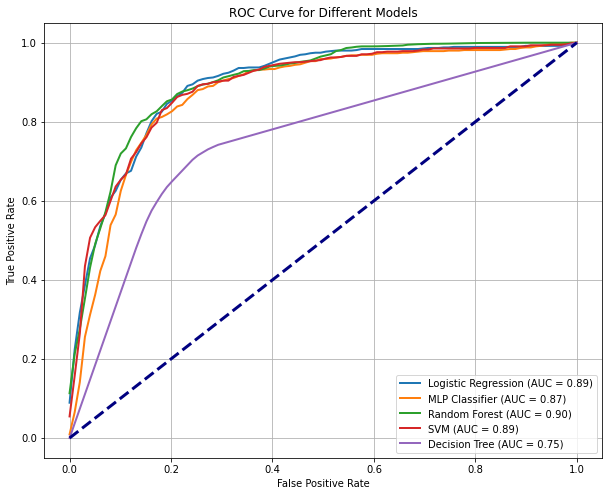

In [8]:
def plot_roc_curve(fpr, tpr, roc_auc, label):
    """绘制单个模型的 ROC 曲线"""
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
# 模型列表
models = {
    'Logistic Regression': linear_model.LogisticRegression(random_state=0),
    'MLP Classifier': MLPClassifier(random_state=0),
    'Random Forest': ensemble.RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0, probability=True),  # SVM 需要设置 probability=True 来计算概率
    'Decision Tree': DecisionTreeClassifier(random_state=0)
}

# 使用 StratifiedKFold 进行 10 折交叉验证
cv = cv_split

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))

for name, clf in models.items():
    # 用于存储每一折的 FPR 和 TPR
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    auc_scores = []

    for train_idx, test_idx in cv.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # 训练模型
        clf.fit(X_train_fold, y_train_fold)
        
        # 预测概率
        y_prob = clf.predict_proba(X_test_fold)[:, 1]
        
        # 计算 FPR 和 TPR
        fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        
        # 对每一折的 FPR 和 TPR 进行插值
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    
    # 计算平均的 TPR
    mean_tpr /= cv.get_n_splits()

    # 计算 AUC 平均值
    mean_auc = np.mean(auc_scores)

    # 绘制当前模型的 ROC 曲线
    plot_roc_curve(mean_fpr, mean_tpr, mean_auc, name)

# 绘制随机模型对角线（假设模型没有预测能力）
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=3)

# 配置图表
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('../Results/1.multiModelAUC_new.pdf',bbox_inches = 'tight')
plt.show()

# 3. Model construction

In [9]:
SEED=0
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_features=0.1, max_samples=0.7, max_depth=3, 
                                      class_weight='balanced', random_state=SEED)
results = model_selection.cross_validate(rfc, X_train, y_train, cv=cv_split, scoring='roc_auc', return_train_score=True)
results

{'fit_time': array([0.08192754, 0.08077145, 0.07460999, 0.07312965, 0.07102513,
        0.07342601, 0.06802416, 0.07129049, 0.07392979, 0.0797255 ]),
 'score_time': array([0.01012158, 0.00700331, 0.00750685, 0.00787091, 0.00799489,
        0.00796032, 0.00914431, 0.00759435, 0.00878334, 0.00801611]),
 'test_score': array([0.90796117, 0.86317152, 0.89553398, 0.90110032, 0.93682848,
        0.90252427, 0.90433657, 0.89087379, 0.88919094, 0.92660194]),
 'train_score': array([0.93623272, 0.94896313, 0.94423963, 0.93669355, 0.92269585,
        0.94043779, 0.94182028, 0.94516129, 0.94648618, 0.93116359])}

In [10]:
param_grid = {'n_estimators':[20,50,100, 200], 
              'max_depth':[1, 2, 3], 
              'max_features':[0.1, 0.2, 0.3], 
              'class_weight':['balanced'],
              'max_samples':[0.3, 0.5,0.7],
              'random_state':[SEED]}
tune_model = model_selection.GridSearchCV(ensemble.RandomForestClassifier(oob_score=True, n_jobs=-1), 
                                          param_grid=param_grid, 
                                          scoring = 'roc_auc', 
                                          cv = cv_split, 
                                          return_train_score=True)
tune_model.fit(X_train, y_train)
tune_model.best_params_
tune_model.cv_results_['mean_train_score'][tune_model.best_index_]
tune_model.cv_results_['mean_test_score'][tune_model.best_index_]

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.4,
            train_size=None),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True),
             param_grid={'class_weight': ['balanced'], 'max_depth': [1, 2, 3],
                         'max_features': [0.1, 0.2, 0.3],
                         'max_samples': [0.3, 0.5, 0.7],
                         'n_estimators': [20, 50, 100, 200],
                         'random_state': [0]},
             return_train_score=True, scoring='roc_auc')

{'class_weight': 'balanced',
 'max_depth': 3,
 'max_features': 0.3,
 'max_samples': 0.5,
 'n_estimators': 200,
 'random_state': 0}

0.9436405529953916

0.9058899676375406

In [11]:
rfc = ensemble.RandomForestClassifier(n_estimators= 200, max_features=0.3, max_samples=0.5, max_depth=3, 
                                      class_weight='balanced', random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train) # Accuracy
rfc.score(X_test, y_test) # Accuracy

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=0.3,
                       max_samples=0.5, n_estimators=200, random_state=0)

0.8584269662921349

0.8523489932885906

# 4. Model performance

## 4.1 training set

roc_auc: 0.9341085271317829


<Figure size 432x432 with 0 Axes>

Text(0.5, 1.0, 'ROC')

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 0, '1 - Specificity')

Text(0, 0.5, 'Sensitivity')

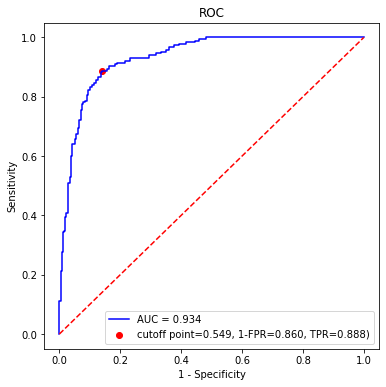

In [12]:
pred = rfc.predict_proba(X_train)[:,1]
#############画图部分训练集AUC
fpr, tpr, threshold = metrics.roc_curve(y_train, pred)
roc_auc = auc(fpr, tpr)
print('roc_auc:', roc_auc)
# 计算Youden's J统计量
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)  # 找到J最大的索引
best_threshold = threshold[best_idx]  # 最佳阈值
best_fpr = 1-fpr[best_idx]  # 最佳阈值对应的FPR
best_tpr = tpr[best_idx]  # 最佳阈值对应的TPR

plt.figure(figsize=(6,6))
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.scatter(1-best_fpr, best_tpr, color='red', label=f'cutoff point={best_threshold:.3f}, 1-FPR={best_fpr:.3f}, TPR={best_tpr:.3f})')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.savefig('../Results/1.3.TrainROC_new.pdf',bbox_inches = 'tight')
plt.show()

In [13]:
# 计算原始AUC
pred = rfc.predict_proba(X_train)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, pred)
roc_auc = auc(fpr, tpr)
print('roc_auc:', roc_auc)

# 自助法（Bootstrap）计算AUC的95%置信区间
n_iterations = 100
auc_scores = []

for i in range(n_iterations):
    # 随机抽样（有放回）
    X_resample, y_resample = resample(X_train, y_train, random_state=i)
    #rfc.fit(X_resample, y_resample)
    y_pred_prob_resample = rfc.predict_proba(X_resample)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_resample, y_pred_prob_resample)
    auc_resample=auc(fpr, tpr)
    auc_scores.append(auc_resample)

# 计算置信区间
auc_lower = np.percentile(auc_scores, 2.5)
auc_upper = np.percentile(auc_scores, 97.5)

print(f"95% CI for AUC: ({auc_lower}, {auc_upper})")

roc_auc: 0.9341085271317829
95% CI for AUC: (0.9115309278311233, 0.9502455412564086)


In [15]:
X_train['predicteScore']=rfc.predict_proba(X_train)[:,1]
X_train['DiagSepsis']=y_train
X_train.to_csv('../Data/trainingSet.csv', index=None)

## 4.2 test set

0.9002399409376154

<Figure size 432x432 with 0 Axes>

Text(0.5, 1.0, 'Validation ROC')

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 0, '1-Specificity')

Text(0, 0.5, 'Sensitivity')

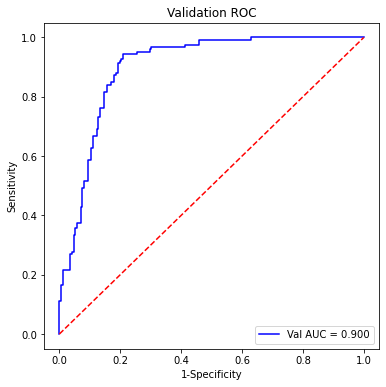

In [14]:
pred = rfc.predict_proba(X_test)[:,1]
#############画图部分
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
roc_auc
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.savefig('../Results/1.3.TestROC_new.pdf',bbox_inches = 'tight')
plt.show()

In [15]:
i = np.arange(len(tpr)) # index for df

roc = pd.DataFrame({'1-Specificity' : pd.Series(fpr, index=i),'Sensitivity' : pd.Series(tpr, index = i), 'Specificity' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})

roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,1-Specificity,Sensitivity,Specificity,tf,threshold
40,0.156977,0.84127,0.843023,-0.001753,0.603006


In [16]:
# 计算原始AUC
pred = rfc.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('roc_auc:', roc_auc)

# 自助法（Bootstrap）计算AUC的95%置信区间
n_iterations = 100
auc_scores = []

for i in range(n_iterations):
    # 随机抽样（有放回）
    X_resample, y_resample = resample(X_test, y_test, random_state=i)
    y_pred_prob_resample = rfc.predict_proba(X_resample)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_resample, y_pred_prob_resample)
    auc_resample=auc(fpr, tpr)
    auc_scores.append(auc_resample)

# 计算置信区间
auc_lower = np.percentile(auc_scores, 2.5)
auc_upper = np.percentile(auc_scores, 97.5)

print(f"95% CI for AUC: ({auc_lower}, {auc_upper})")

roc_auc: 0.9002399409376154
95% CI for AUC: (0.862192084533414, 0.9257768195922497)


In [17]:
X_test['predicteScore']=rfc.predict_proba(X_test)[:,1]
X_test['DiagSepsis']=y_test
X_test.to_csv('../Data/testSet_new.csv', index=None)